<a href="https://colab.research.google.com/github/PKRaj007/PKRaj007/blob/main/OnePixelAttack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib
from keras.datasets import cifar10
from keras import backend as K
import matplotlib.pyplot as plt



In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 13s 0us/step


In [ ]:
x_train.shape

(50000, 32, 32, 3)

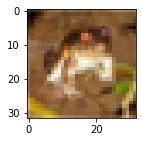

In [ ]:
#x_train[0]
plt.figure(figsize=(15,2))
plt.imshow(x_train[0])

In [ ]:
# 50000 samples and one dimentional array difing class
y_train.shape

(50000, 1)

In [ ]:
y_train[:5] #first class 6 means-frog level(categories)

array([[6],
       [9],
       [9],
       [4],
       [1]], dtype=uint8)

**Convert this 2d array into 1d array**

In [ ]:
y_train=y_train.reshape(-1,) # we don't change 1st dimention 50000 so left it as -1 
#and instead of [6] we for convert it in 1d array left it blank.
y_train[:5]

array([6, 9, 9, 4, 1], dtype=uint8)

In [ ]:
x_test.shape

(10000, 32, 32, 3)

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
class_names[7]

'horse'

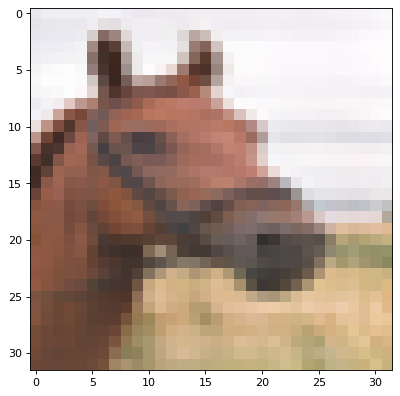

In [ ]:
image_id = 99 # Image index in the test set
plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.imshow(x_test[image_id]);

In [ ]:
import helper

In [ ]:
help(helper)

Perturbing Image

In [ ]:
def perturb_image(xs, img):
  #xs perturbations [x,y,r,g,b]
    # If this function is passed just one perturbation vector (one pixel perturbation),
    # pack it in a list to keep the computation the same
    if xs.ndim < 2:
        xs = np.array([xs])
    print(xs)
    # Repet this on image n == len(xs) times so that we can 
    # create n new perturbed images
    tile = [len(xs)] + [1]*(xs.ndim+1)
    
    imgs = np.tile(img, tile)
    
    # Make sure to floor the members of xs as int types
    xs = xs.astype(int)
    
    for x,img in zip(xs, imgs):
        # Split x ( single pixel) into an array of 5-tuples (perturbation pixels)
        # i.e., [[x,y,r,g,b], ...]
        pixels = np.split(x, len(x) // 5)
        #split seprate array into its single elements (seperator,maxsplit);
        for pixel in pixels:
            # At each pixel's x,y position, assign its rgb value
            x_pos, y_pos, *rgb = pixel
            img[x_pos, y_pos] = rgb
    
    return imgs

**Design Model** 
- All Conv

In [ ]:
import cv2
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Flatten,Conv2D,Activation,Dropout
from keras import backend as K

import keras
from keras.models import Sequential, Model
from keras.models import load_model
from tensorflow.keras.optimizers import SGD
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import MaxPool2D
from keras.layers.pooling import AvgPool2D
from google.colab.patches import cv2_imshow
from keras.layers import *
from keras import Input

In [ ]:
def allConvModel(input, num_classes):
  input = Input(shape = (32,32,3))
  #changing filters from 64 -> 16
  layer_1 = Conv2D(filters=96, kernel_size=(3,3), padding="same", activation="relu")(input)
  layer_2 = Conv2D(filters=96, kernel_size=(3,3), padding="same", activation="relu")(layer_1)
  layer_3 = Conv2D(filters=96, kernel_size=(3,3), padding="same", strides=2, activation="relu")(layer_2)
  layer_4 = Conv2D(filters=192, kernel_size=(3,3), padding="same", activation="relu")(layer_3)
  layer_5 = Conv2D(filters=192, kernel_size=(3,3), padding="same", activation="relu")(layer_4)

  dropout_layer = Dropout(rate=0.3, seed=None)(layer_5)

  layer_6 = Conv2D(filters=192, kernel_size=(3,3), strides=2, padding="same", activation="relu")(dropout_layer)
  layer_7 = Conv2D(filters=192, kernel_size=(3,3), strides=2, padding="same", activation="relu")(layer_6)
  layer_8 = Conv2D(filters=192, kernel_size=(1,1), padding="same", activation="relu")(layer_7)
  layer_9 = Conv2D(filters=10, kernel_size=(1,1), padding="same", activation="relu")(layer_8)

  avg_pooling_layer = AveragePooling2D(pool_size=(4,4))(layer_9)
  flatten_layer = Flatten()(avg_pooling_layer)
  # flatten_layer = Dense(num_classes, activation = 'sigmoid')(avg_pooling_layer)
  activation_layer = Dense(num_classes, activation = 'sigmoid')(flatten_layer)
  
  allConvModel = Model(inputs=input,outputs=activation_layer)
  return allConvModel

input = Input(shape = (32,32,3))
allConv = allConvModel(input, 10)
allConv.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 96)        2688      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 96)        83040     
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 96)        83040     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 192)       166080    
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 192)       331968    
                                                                 
 dropout (Dropout)           (None, 16, 16, 192)       0     

**Train Model**

In [ ]:
from tensorflow.keras.optimizers import SGD
import tensorflow.keras.metrics as tfm

In [ ]:
# opt = SGD(learning_rate=0.001)
#allConv.compile(optimizer='adam',loss = 'categorical_crossentropy', metrics=['accuracy'])

In [ ]:
allConv.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
# categorical_crossentropy use in case of one hot encode target values
# from tensorflow.keras.utils import to_categorical
# y_train = to_categorical(y_train)
# y_test = to_categorical(y_test)

In [ ]:
allConv_results = allConv.fit(x_train, y_train, epochs=30, batch_size=64, verbose=1)

Epoch 1/5
782/782 [==============================] - 20s 25ms/step - loss: 2.3027 - accuracy: 0.0976
Epoch 2/5
782/782 [==============================] - 20s 25ms/step - loss: 2.3027 - accuracy: 0.0976
Epoch 3/5
782/782 [==============================] - 20s 25ms/step - loss: 2.3027 - accuracy: 0.0959
Epoch 4/5
782/782 [==============================] - 20s 26ms/step - loss: 2.3027 - accuracy: 0.0989
Epoch 5/5
782/782 [==============================] - 20s 26ms/step - loss: 2.3027 - accuracy: 0.0987


In [ ]:
#history = allConv.fit(x_train, y_train, epochs=5, batch_size=64, verbose=1)

In [ ]:
#loss_train = history.history['loss']
#loss_val =history.history['loss']
#epochs = range(1,5)
#plt.plot(epochs, loss_train, 'g', label='loss')
#plt.plot(epochs, loss_val, 'b', label='loss')
#plt.title('Training and Validation loss')
#plt.xlabel('Epochs')
#plt.ylabel('Loss')
#plt.legend()
#plt.show()

In [ ]:
_, acc = allConv.evaluate(x_test, y_test, verbose=0)
print(acc)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


0.10000000149011612


In [ ]:
print(x_train.shape, y_test.shape, x_test.shape, y_train.shape)

(50000, 32, 32, 3) (10000, 1) (10000, 32, 32, 3) (50000,)


In [ ]:
allConv.predict(x_test)
#y_pred=allConv.predict(x_test)

array([[0.500207  , 0.4964611 , 0.50207746, ..., 0.5008513 , 0.4988632 ,
        0.5016205 ],
       [0.500207  , 0.4964611 , 0.50207746, ..., 0.5008513 , 0.4988632 ,
        0.5016205 ],
       [0.500207  , 0.4964611 , 0.50207746, ..., 0.5008513 , 0.4988632 ,
        0.5016205 ],
       ...,
       [0.500207  , 0.4964611 , 0.50207746, ..., 0.5008513 , 0.4988632 ,
        0.5016205 ],
       [0.500207  , 0.4964611 , 0.50207746, ..., 0.5008513 , 0.4988632 ,
        0.5016205 ],
       [0.500207  , 0.4964611 , 0.50207746, ..., 0.5008513 , 0.4988632 ,
        0.5016205 ]], dtype=float32)

In [ ]:
y_class_names = [np.argmax(element) for element in y_pred]
y_class_names[:5]

[3, 3, 3, 3, 3]

In [ ]:
y_test[:5]

array([[3],
       [8],
       [8],
       [0],
       [6]], dtype=uint8)

In [ ]:
class_names[y_class_names[6]]

'cat'

1 Pixel Attack

In [ ]:
!pip install tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 8.1 MB/s 


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from pathlib import Path
from tensorboardX import SummaryWriter
from torchvision import datasets, transforms, models
from tqdm import tqdm

writer = SummaryWriter()
sns.set()
sns.set_style("dark")
sns.set_palette("muted")
sns.set_color_codes("muted")

In [ ]:
from numpy.random import rand
from numpy.random import choice
from numpy import asarray
from numpy import clip
from numpy import argmin
from numpy import min
from numpy import around
from matplotlib import pyplot
import pytest
import math

# define objective function
def obj(x):
    return x[0]**2.0 + x[1]**2.0


# define mutation operation
def mutation(x, F):
    return x[0] + F * (x[1] - x[2])


# define boundary check operation
def check_bounds(mutated, bounds):
    mutated_bound = [clip(mutated[i], bounds[i, 0], bounds[i, 1]) for i in range(len(bounds))]
    return mutated_bound


# define crossover operation
def crossover(mutated, target, dims, cr):
    # generate a uniform random value for every dimension
    p = rand(dims)
    # generate trial vector by binomial crossover
    trial = [mutated[i] if p[i] < cr else target[i] for i in range(dims)]
    return trial


def differential_evolution(predict_fn, bounds, maxiter, popsize,
        recombination=1, atol=-1):
    # initialise population of candidate solutions randomly within the specified bounds
    pop = bounds[:, 0] + (rand(popsize, len(bounds)) * (bounds[:, 1] - bounds[:, 0]))
    print('Pop = ',pop)
    # evaluate initial population of candidate solutions
    obj_all = [obj(ind) for ind in pop]
    print(obj_all)
    # find the best performing vector of initial population
    best_vector = pop[argmin(obj_all)]
    best_obj = min(obj_all)
    prev_obj = best_obj
    # initialise list to store the objective function value at each iteration
    obj_iter = list()
    # run iterations of the algorithm
    for i in range(iter):
        # iterate over all candidate solutions
        for j in range(popsize):
            # choose three candidates, a, b and c, that are not the current one
            candidates = [candidate for candidate in range(popsize) if candidate != j]
            a, b, c = pop[choice(candidates, 3, replace=False)]
            # perform mutation
            mutated = mutation([a, b, c], F)
            # check that lower and upper bounds are retained after mutation
            trial = check_bounds(mutated, bounds)
            # perform crossover
            # trial = crossover(trial, pop[j], len(bounds), cr)
            # compute objective function value for target vector
            obj_target = obj(pop[j])
            # compute objective function value for trial vector
            obj_trial = obj(trial)
            # perform selection
            # print('Prior : ',pop[j])
            if obj_trial < obj_target:
                # replace the target vector with the trial vector
                pop[j] = trial
                # store the new objective function value
                obj_all[j] = obj_trial
            # print('After : ',pop[j])
        # find the best performing vector at each iteration
        best_obj = min(obj_all)
        # store the lowest objective function value
        if best_obj < prev_obj:
            best_vector = pop[argmin(obj_all)]
            prev_obj = best_obj
            obj_iter.append(best_obj)
            # report progress at each iteration
            print('Iteration: %d f([%s]) = %.5f' % (i, around(best_vector, decimals=5), best_obj))
        
        # if(math.isclose(0.00000,best_obj, abs_tol = 10**-5)):
        #   break
        
        #if best_obj == pytest.approx(0.00000):
        # print('iter = ',i)
        # break
    return [best_vector, best_obj, obj_iter]
    print(best_vector, best_obj, obj_iter)

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {'num_workers': 4}
print("CUDA Available:", torch.cuda.is_available())

CUDA Available: True


In [ ]:
cifar_model = models.vgg16(pretrained=True, init_weights=False)
cifar_model.classifier = nn.Sequential(
        nn.Linear(25088, 2048),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(2048, 2048),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(2048, 10),
    )
cifar_model = cifar_model.to(DEVICE)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
BATCH_SIZE = 128
TRAIN_COUNT = 40_000
VAL_COUNT = 10_000
TEST_COUNT = 10_000

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_transform = transforms.ToTensor()

train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_set = torch.utils.data.dataset.Subset(train_set, range(0,TRAIN_COUNT))
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, **LOADER_KWARGS)

val_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=test_transform)
val_set = torch.utils.data.dataset.Subset(val_set, range(TRAIN_COUNT,TRAIN_COUNT+VAL_COUNT))
val_loader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, **LOADER_KWARGS)

test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, **LOADER_KWARGS)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def test(epoch=None, is_validation=False):
    cifar_model.eval()
    loader = val_loader if is_validation else test_loader
    test_loss = 0
    test_correct = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = cifar_model(inputs)
            test_loss += F.cross_entropy(outputs, targets, size_average=False).item()
            test_correct += outputs.max(1)[1].eq(targets).sum().item()
    if is_validation:
        writer.add_scalar('logs/val_loss', test_loss/len(loader.dataset), epoch)
        writer.add_scalar('logs/val_acc', test_correct/len(loader.dataset), epoch)
    else:
        print("Test Accuracy: {}/{}".format(test_correct, len(loader.dataset)))

In [ ]:
optimizer = optim.Adam(cifar_model.parameters())

# Training
def train(epoch):
    cifar_model.train()
    epoch_loss = 0
    epoch_correct = 0
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        optimizer.zero_grad()
        outputs = cifar_model(inputs)
        loss = F.cross_entropy(outputs, targets)
        loss.backward()
        optimizer.step()
        batch_correct = outputs.max(1)[1].eq(targets).sum().item()
        epoch_loss += loss.item()
        epoch_correct += batch_correct
        writer.add_scalar('logs/train_loss', loss.item(), epoch*len(train_loader) + batch_idx)
        writer.add_scalar('logs/train_acc', batch_correct / targets.size(0), epoch*len(train_loader) + batch_idx)
    test(epoch, is_validation=True)

In [ ]:
TRAIN_EPOCHS = 20
WEIGHTS_PATH = Path("./vgg_cifar_weights.pt")

if WEIGHTS_PATH.is_file():
    cifar_model.load_state_dict(torch.load(WEIGHTS_PATH))
    print("Loaded weights from file:", WEIGHTS_PATH)
else:
    for epoch in range(TRAIN_EPOCHS):
        train(epoch)
    torch.save(cifar_model.state_dict(), WEIGHTS_PATH)

100%|██████████| 313/313 [00:27<00:00, 11.28it/s]
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 313/313 [00:26<00:00, 11.80it/s]


In [ ]:
test()

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Test Accuracy: 1000/10000


In [ ]:
CIFAR_LABELS = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

def tell(img, label, model, target_label=None):
    print("True Label:", CIFAR_LABELS[label], label)
    print("Prediction:", CIFAR_LABELS[model(img.unsqueeze(0)).max(-1)[1]], model(img.unsqueeze(0)).max(-1)[1][0].item())
    print("Label Probabilities:", F.softmax(model(img.unsqueeze(0)).squeeze(), dim=0))
    print("True Label Probability:", F.softmax(model(img.unsqueeze(0)).squeeze(), dim=0)[label].item())
    if target_label is not None:
        print("Target Label Probability:", F.softmax(model(img.unsqueeze(0)).squeeze(), dim=0)[target_label].item())

True Label: deer 4
Prediction: horse 7
Label Probabilities: tensor([0.0999, 0.0997, 0.1007, 0.0997, 0.1001, 0.0986, 0.1008, 0.1009, 0.1000,
        0.0996], device='cuda:0', grad_fn=<SoftmaxBackward0>)
True Label Probability: 0.10006055980920792


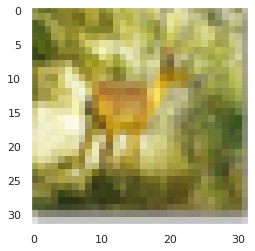

In [ ]:
test_img, test_label = test_set[500]
test_img = test_img.to(DEVICE)
show(test_img)
tell(test_img, test_label, cifar_model)

Perturbation: [0.6  0.6  0.   0.   0.75]
True Label: deer 4
Prediction: horse 7
Label Probabilities: tensor([0.0999, 0.0997, 0.1007, 0.0997, 0.1001, 0.0986, 0.1008, 0.1009, 0.1000,
        0.0996], device='cuda:0', grad_fn=<SoftmaxBackward0>)
True Label Probability: 0.10006055980920792


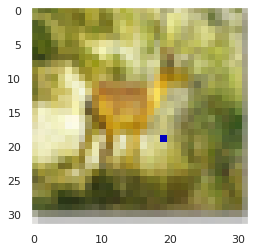

In [ ]:
def perturb(p, img):
    # Elements of p(perturbation)[x,y,r,g,b] should be in range [0,1]
    img_size = img.size(1) # C x _H_ x W, assume H == W
    p_img = img.clone()  #image each pixcels
    xy = (p[0:2].copy() * img_size).astype(int)
    xy = np.clip(xy, 0, img_size-1)
    rgb = p[2:5].copy()
    rgb = np.clip(rgb, 0, 1)
    p_img[:,xy[0],xy[1]] = torch.from_numpy(rgb) # Changing color of xy pixel
    return p_img

def visualize_perturbation(p, img, label, model, target_label=None):
    p_img = perturb(p, img) #pertubeted image
    print("Perturbation:", p) #p=[x,y,r,g,b]
    show(p_img)
    tell(p_img, label, model, target_label)

visualize_perturbation(np.array([0.6,0.6,0,0,0.75]), test_img, test_label, cifar_model)

Target Probability [Iteration 0]: 0.10006055980920792
Target Probability [Iteration 10]: 0.10006055980920792
Target Probability [Iteration 20]: 0.10006055980920792
Target Probability [Iteration 30]: 0.10006055980920792
Target Probability [Iteration 40]: 0.10006055980920792
Target Probability [Iteration 50]: 0.10006055980920792
Target Probability [Iteration 60]: 0.10006055980920792
Target Probability [Iteration 70]: 0.10006055980920792
Target Probability [Iteration 80]: 0.10006055980920792
Target Probability [Iteration 90]: 0.10006055980920792
Perturbation: [0.23179133 0.69193141 0.40170404 0.         0.5466625 ]
True Label: deer 4
Prediction: horse 7
Label Probabilities: tensor([0.0999, 0.0997, 0.1007, 0.0997, 0.1001, 0.0986, 0.1008, 0.1009, 0.1000,
        0.0996], device='cuda:0', grad_fn=<SoftmaxBackward0>)
True Label Probability: 0.10006055980920792


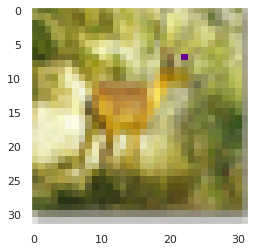

In [ ]:
# Pertube and tells the probability
def evaluate(candidates, img, label, model):
    preds = []
    model.eval()
    with torch.no_grad():
        for i, xs in enumerate(candidates):
            p_img = perturb(xs, img) #perturbated image by xs=[x,y,r,g,b]
            preds.append(F.softmax(model(p_img.unsqueeze(0)).squeeze(), dim=0)[label].item())
    return np.array(preds)

# Generates Child and Return(Mutate)
def evolve(candidates, F=0.5, strategy="clip"):
    gen2 = candidates.copy()
    num_candidates = len(candidates)
    for i in range(num_candidates):
        x1, x2, x3 = candidates[np.random.choice(num_candidates, 3, replace=False)]
        x_next = (x1 + F*(x2 - x3))
        if strategy == "clip":
            gen2[i] = np.clip(x_next, 0, 1)
        elif strategy == "resample":
            x_oob = np.logical_or((x_next < 0), (1 < x_next))
            x_next[x_oob] = np.random.random(5)[x_oob]
            gen2[i] = x_next
    return gen2

def attack(model, img, true_label, target_label=None, iters=100, pop_size=400, verbose=True):
    # Targeted: maximize target_label if given (early stop > 50%)
    # Untargeted: minimize true_label otherwise (early stop < 5%)
    candidates = np.random.random((pop_size,5)) # take array of 400(pixel),5(xyrgb) and fill with [0,1)
    # means 400 diff perturbated images are found in each iteration(Generation)
    candidates[:,2:5] = np.clip(np.random.normal(0.5, 0.5, (pop_size, 3)), 0, 1)
    is_targeted = target_label is not None
    label = target_label if is_targeted else true_label
    fitness = evaluate(candidates, img, label, model)
    
    def is_success():
        return (is_targeted and fitness.max() > 0.5) or ((not is_targeted) and fitness.min() < 0.05)
    
    for iteration in range(iters):
        # Early Stopping
        if is_success():
            break
        if verbose and iteration%10 == 0: # Print progress
            print("Target Probability [Iteration {}]:".format(iteration), fitness.max() if is_targeted else fitness.min())
        # Generate new candidate solutions
        new_gen_candidates = evolve(candidates, strategy="resample")
        # Evaluate new solutions
        new_gen_fitness = evaluate(new_gen_candidates, img, label, model)
        # Replace old solutions with new ones where they are better
        successors = new_gen_fitness > fitness if is_targeted else new_gen_fitness < fitness
        candidates[successors] = new_gen_candidates[successors] # Updte candidatea
        fitness[successors] = new_gen_fitness[successors]
    best_idx = fitness.argmax() if is_targeted else fitness.argmin()
    best_solution = candidates[best_idx]
    best_score = fitness[best_idx]
    if verbose:
        visualize_perturbation(best_solution, img, true_label, model, target_label)
    return is_success(), best_solution, best_score

# Untargeted attack
_ = attack(cifar_model, test_img, test_label)

In [ ]:
# Targeted attack
# This is much harder/costlier than an untargeted attack
# For time reasons, targeted attacks below use 20 iterations
targeted_results = {}
for idx in range(len(CIFAR_LABELS)):
    if idx != test_label:
        targeted_results[idx] = attack(cifar_model, test_img, test_label, target_label=idx, iters=20, verbose=False)
        print(CIFAR_LABELS[idx], idx, targeted_results[idx][0], targeted_results[idx][2])
    else:
        print(CIFAR_LABELS[idx], idx, "True Label")

airplane 0 False 0.09994594007730484
automobile 1 False 0.09974901378154755
bird 2 False 0.10068761557340622
cat 3 False 0.09967490285634995
deer 4 True Label
dog 5 False 0.09864164888858795
frog 6 False 0.10080868005752563
horse 7 False 0.10087330639362335
ship 8 False 0.09996559470891953
truck 9 False 0.09959271550178528
